In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# First look at the data

In [2]:
df = pd.read_json('data/Graduate - HEADLINES dataset (2019-06).json', lines=True)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.shape

(26709, 2)

In [4]:
df.isna().any()

headline        False
is_sarcastic    False
dtype: bool

In [5]:
df.dtypes

headline        object
is_sarcastic     int64
dtype: object

In [6]:
df['headline'] = df['headline'].astype('string')

In [7]:
df['headline'].str.len().mean()

60.910591935302705

In [8]:
df['headline'].str.len().min()

7

Let's take a look at the shortest headline that we have. It is not sarcastic.

In [9]:
df.loc[df['headline'].str.len() == 7]

,headline,is_sarcastic
20551,bye bye,0


In [10]:
df['headline'].str.len().max()

254

In the opposite, the longest one is sarcastic.

In [11]:
df.loc[df['headline'].str.len() == 254]

,headline,is_sarcastic
19868,"maya angelou, poet, author, civil rights activ...",1


In [12]:
df.loc[df['headline'].str.len() == 254, 'headline'].values

<StringArray>
['maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86']
Length: 1, dtype: string

# Preprocessing

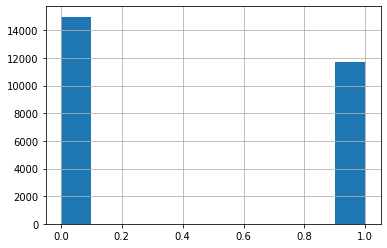

In [13]:
df['is_sarcastic'].hist();

The internet is full of emoticons. Maybe it would be a good idea to leave them? Sarcastic headlines may contain more of them than non-sarcastic headlines.

It turns out there is very few of them, so I will get read of them, not to make my data noisy.

In [18]:
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")

for i in range(len(df)):
    match = RE_EMOTICONS.search(df.loc[i, 'headline'])
    if match is not None:
        print(f'Emoticon found: {match[0]}, is its headline sarcastic? {df.loc[i, "is_sarcastic"]}')

Emoticon found: ):, is its headline sarcastic? 0
Emoticon found: ):, is its headline sarcastic? 0


I will also take a look at most popular tokens that appear in the headlines

In [41]:
tokens = []
for i in range(len(df)):
    tokens += word_tokenize(df.loc[i, 'headline'])

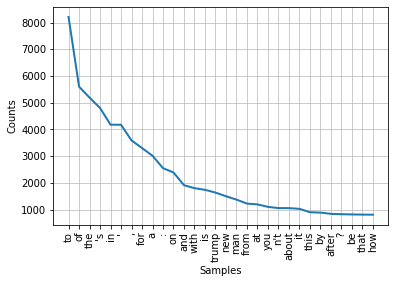

In [44]:
freq_dist = FreqDist(tokens)
freq_dist.plot(30)
plt.show()

It is not a suprise that some stop words appear in the chart, but there are also some other words, like "Trump" or "man". I will compare the results with the one I obtain after some preprocessing. 

In particular, I will:
- remove punctuation, stopwords and unnecessary spaces
- lowercase the words
- tokenize
- lemmatize based on WordNet

In [77]:
class Preprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, remove_digits=False):
            self.remove_digits=remove_digits
            self.stop_words = set(sw.words('english'))
            self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.tokenize(headline) for headline in X]
    
    def tokenize(self, headline, join=True):
        tokens = []
        for token, tag in pos_tag(wordpunct_tokenize(headline)):
            token = self.normalize(token)
            
            if token in self.stop_words:
                continue
                
            if len(token) <= 1:
                continue
                                  
            lemmatized = self.lemmatize(token, tag)
            tokens.append(lemmatized)
            
        if join:
            return ' '.join(tokens)
        else: 
            return tokens
        
    def normalize(self, text):
        if self.remove_digits:
            text = re.sub(r'\d+', '', text)
        text = self.remove_punctuation(text)
        text = text.strip().lower()
        return text
    
    def remove_punctuation(self, text):
        text = ''.join([c for c in text if c not in string.punctuation ])
        return text
                                  
    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
        

In [63]:
tokens_preprocessed = []
preprocessor = Preprocessor()
for i in range(len(df)):
    tokens_preprocessed += preprocessor.tokenize(df.loc[i, 'headline'], join=False)

After applying preprocessing steps I get much more meaningful results. This time "Trump" tops the list of most frequent words. Politics seems really popular topic of the headlines, what is not a suprise. One can find "Obama", "american", "nation" at the list too.

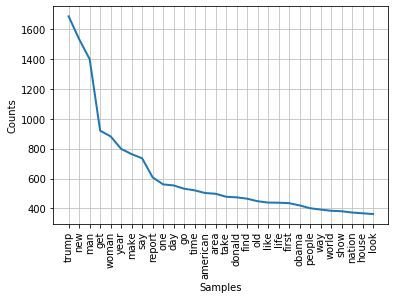

In [73]:
freq_dist_preprocessed = FreqDist(tokens_preprocessed)
freq_dist_preprocessed.plot(30)
plt.show()

In [74]:
def plot_wordcloud(wordcloud):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

What also helps us to understand the text data we are working with are wordclouds

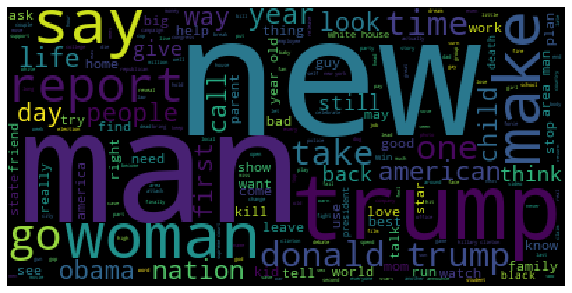

In [75]:
wordcloud = WordCloud().generate(' '.join(tokens_preprocessed))
plot_wordcloud(wordcloud)

Let's take a look at a few of the headlines itself

In [78]:
preprocessed = Preprocessor().fit_transform(df['headline'], df['is_sarcastic'])
preprocessed[:5]

['former versace store clerk sue secret black code minority shopper',
 'roseanne revival catch thorny political mood good bad',
 'mom start fear son web series closest thing grandchild',
 'boehner want wife listen come alternative debt reduction idea',
 'rowling wish snape happy birthday magical way']

In [95]:
df_train_test = df.copy()
y, X = df['is_sarcastic'], df['headline']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Pipeline(steps=[
    ('preprocessor', Preprocessor()),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7857231998003245